<a href="https://colab.research.google.com/github/pinballsurgeon/NLP_Engine_Study/blob/main/protein_tfidf_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from   time import time
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20

df = pd.read_csv("protein_csv.csv",)


In [2]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [3]:
buf_list = []

for seq in df['protein']:
  buf_string = ''
  for amino in seq:
    buf_string = buf_string + amino + ' '
  buf_list.append(buf_string)
df['protein split'] = buf_list

In [4]:
df['protein split']

0    M A M A V S G A V L S G L G S S F L T G G K R ...
1    M A M A A V T G A V L S G L G S S F L S G G K ...
2    M A M A I S G A V L S G L G S S F L T G G K R ...
3    M A M A A V T G A V L S G L G S S F L S G G K ...
4    M A M A A V T G A V L S G L G S S F L S G G K ...
5    M A T T S A P V L N G L S S S F L T G G K K N ...
6    M A T T S A A V L N G L S S S F L T G G K N S ...
Name: protein split, dtype: object

Extracting tf-idf features for NMF...
done in 0.030s.
Extracting tf features for LDA...
done in 0.018s.

Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=2000 and n_features=1000...
done in 0.019s.


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1425: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


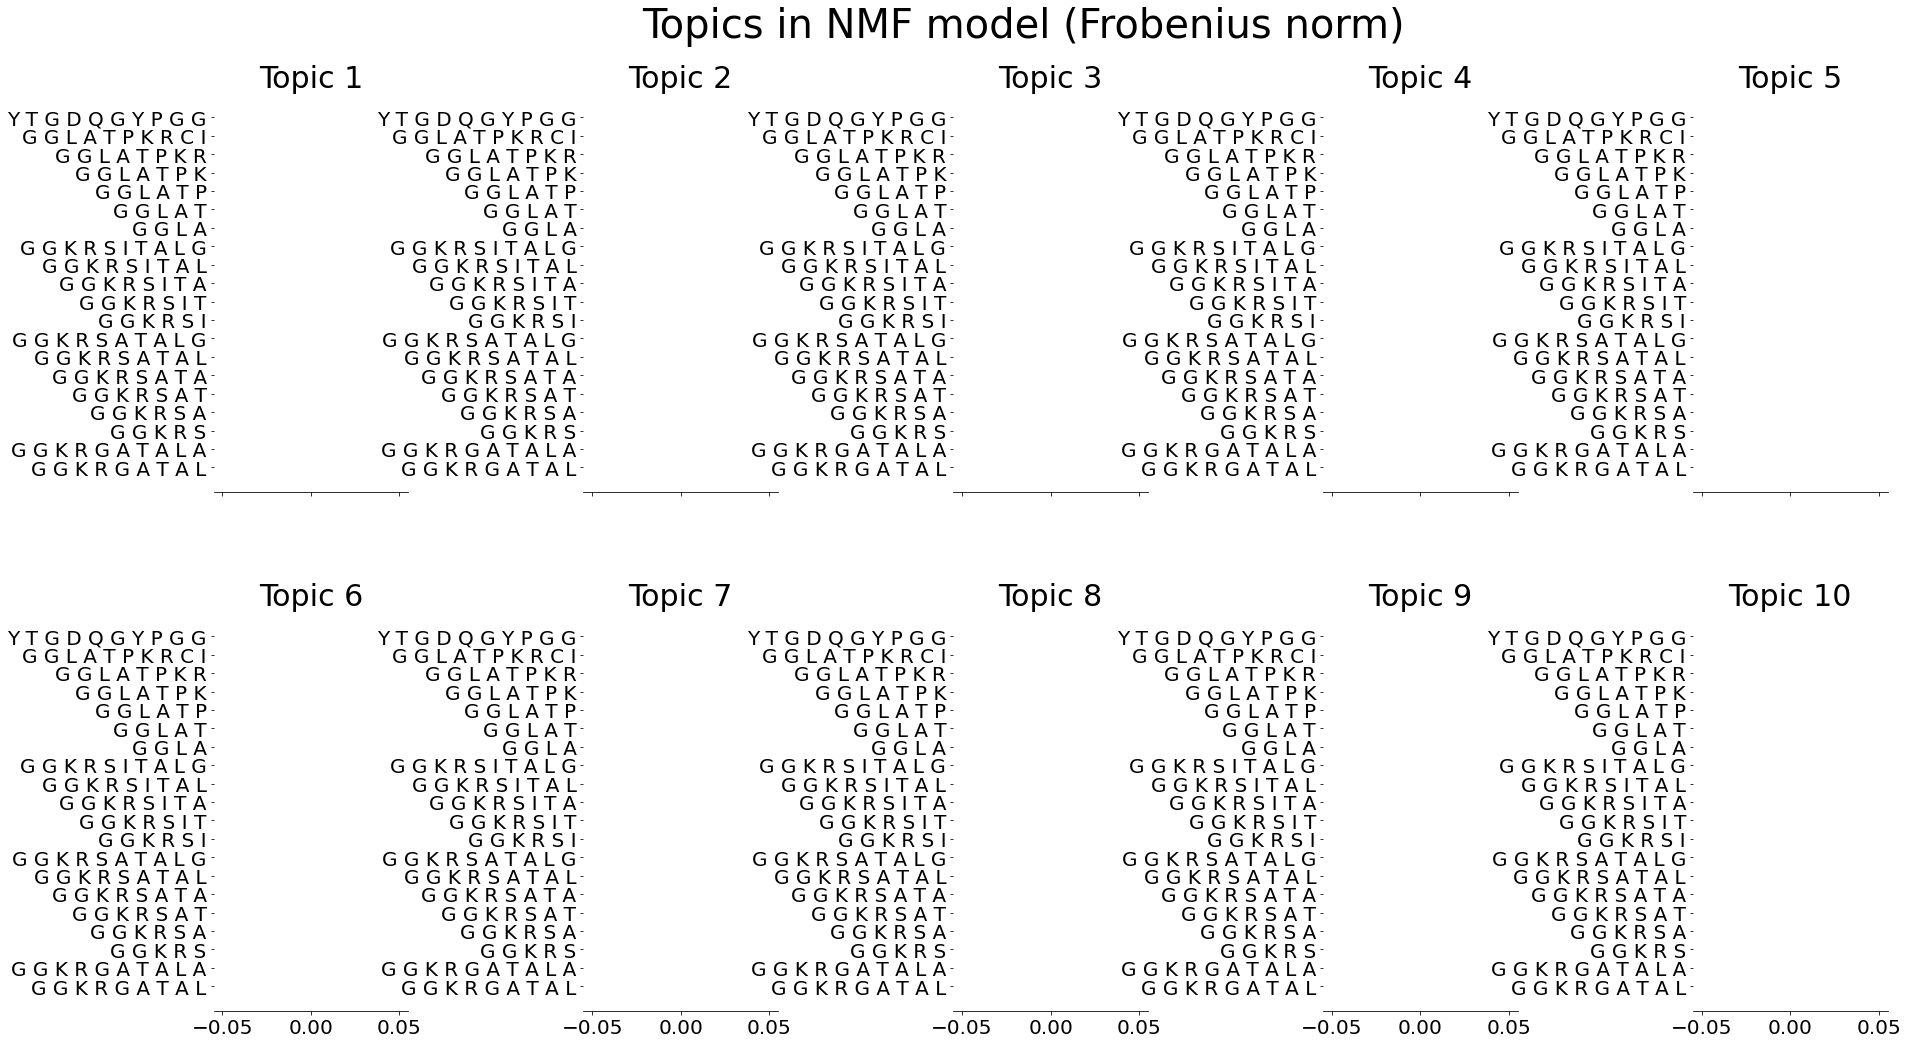



 Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=2000 and n_features=1000...


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1425: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


done in 1.720s.


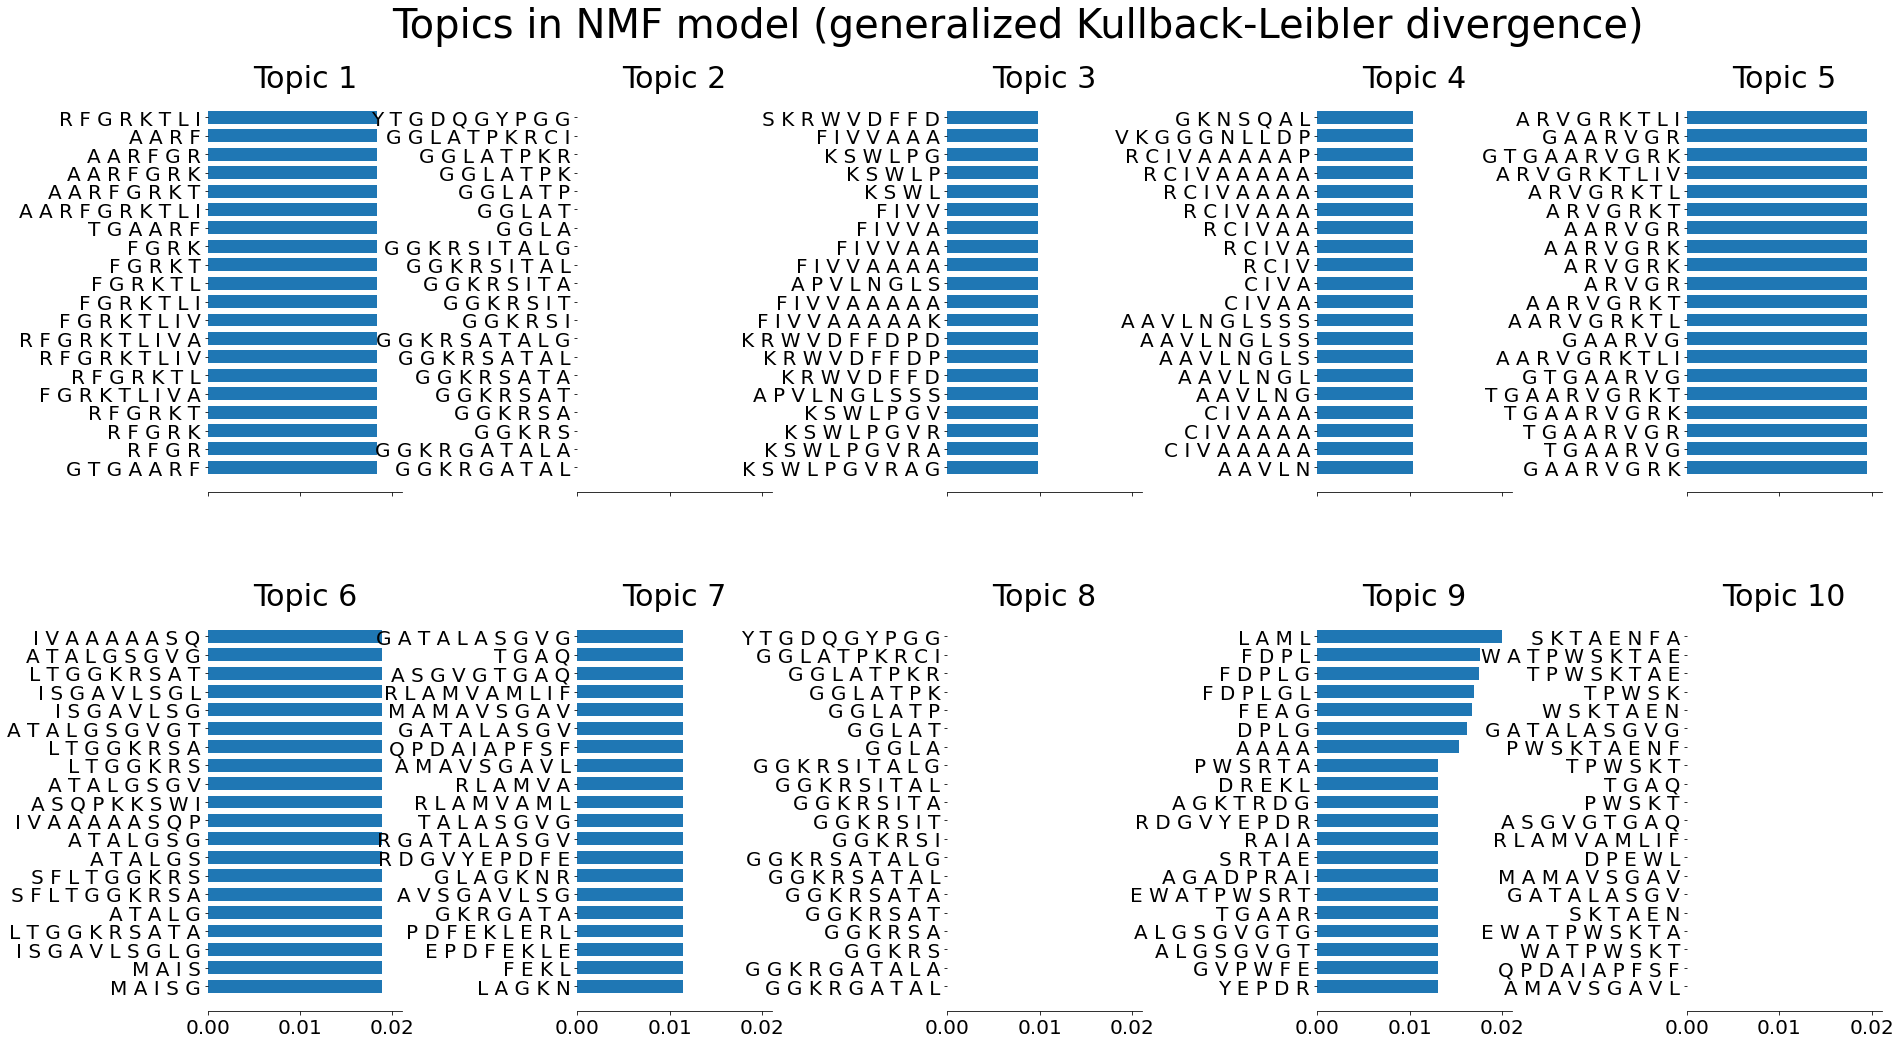



 Fitting LDA models with tf features, n_samples=2000 and n_features=1000...
done in 0.321s.


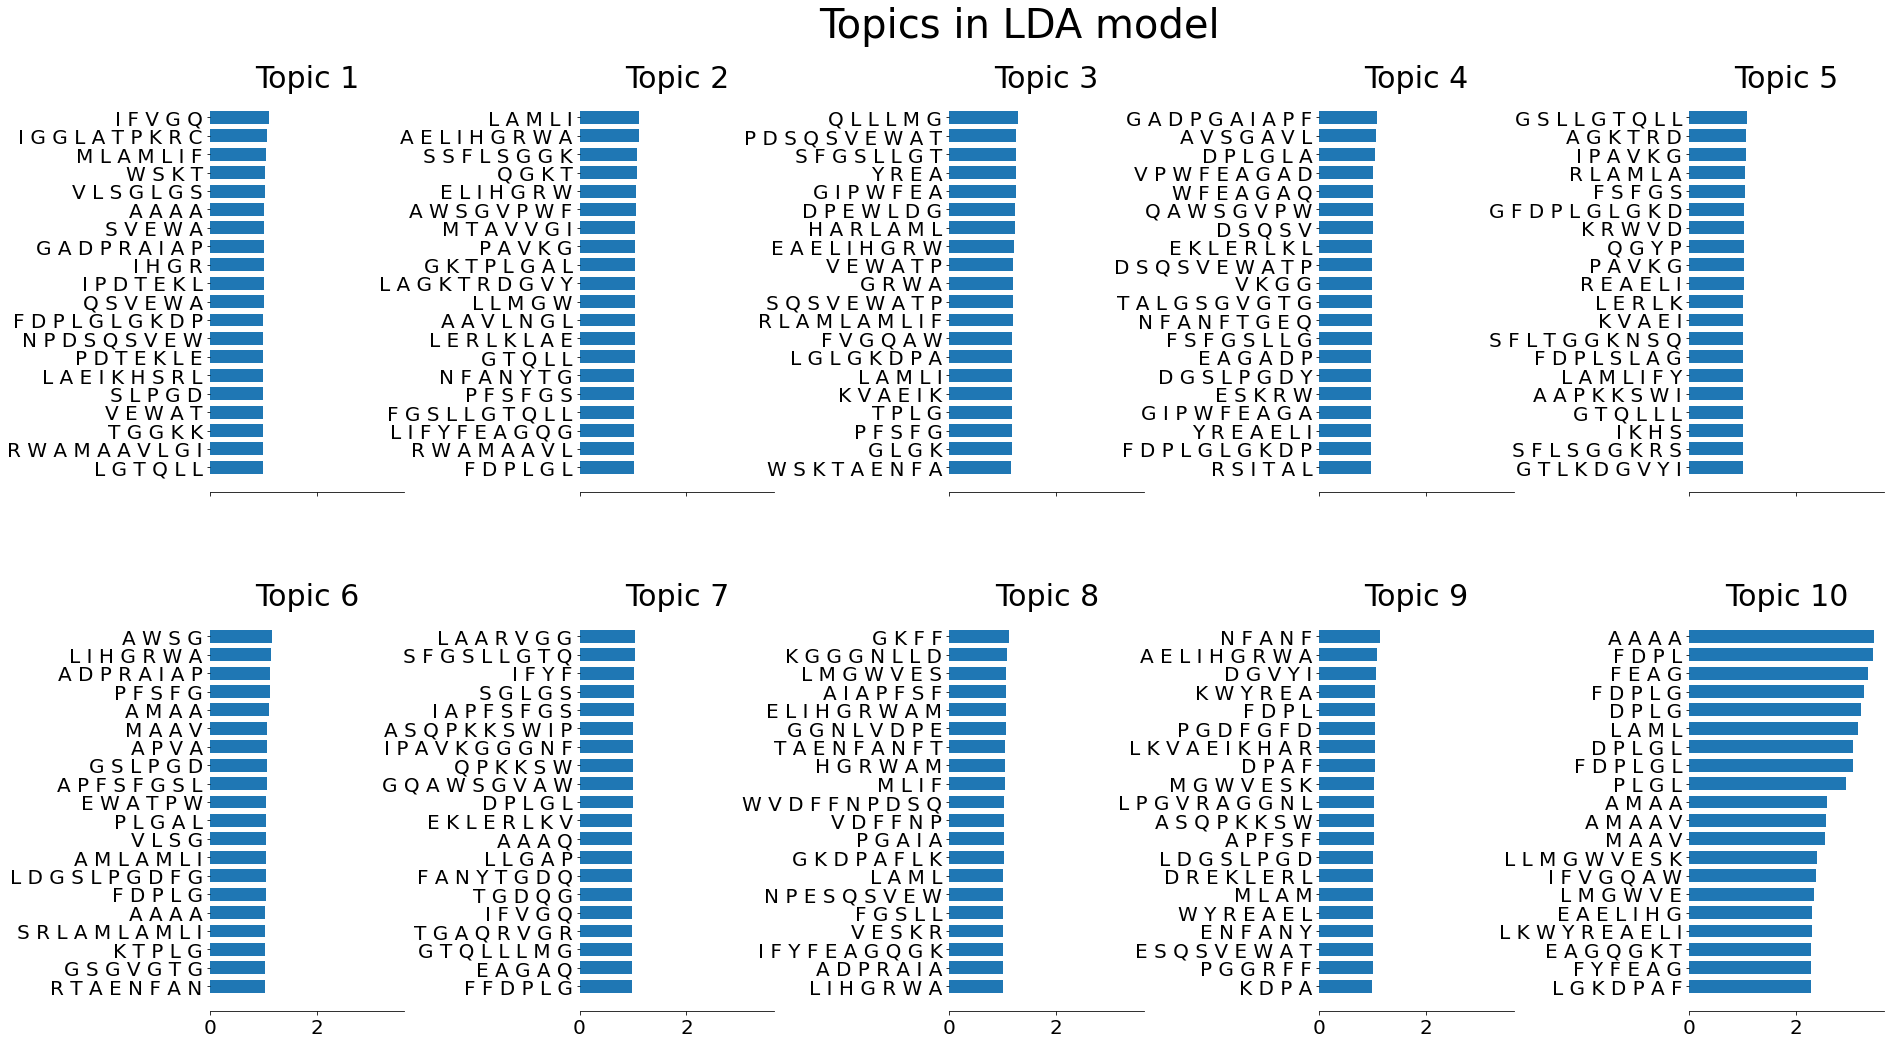

In [5]:

data_samples = df['protein split']

# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(
                                  token_pattern='(?u)\\b\\w+\\b'
                                , lowercase=False
                                , ngram_range=(4, 10)   
                                #    max_df=1
                                #  , min_df=2
                                #    max_features=n_features
                                #  , stop_words="english"
)
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(
                                  token_pattern='(?u)\\b\\w+\\b'
                                , lowercase=False
                                , ngram_range=(4, 10) 
                                #    max_df=1
                                #  , min_df=2
                                #   max_features=n_features
                                #  , stop_words="english"
)
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))
print()

# Fit the NMF model
print(
    "Fitting the NMF model (Frobenius norm) with tf-idf features, "
    "n_samples=%d and n_features=%d..." % (n_samples, n_features)
)
t0 = time()
nmf = NMF(n_components=n_components, random_state=1, alpha=0.1, l1_ratio=0.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))


tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf, tfidf_feature_names, n_top_words, "Topics in NMF model (Frobenius norm)"
)

# Fit the NMF model
print(
    "\n" * 2,
    "Fitting the NMF model (generalized Kullback-Leibler "
    "divergence) with tf-idf features, n_samples=%d and n_features=%d..."
    % (n_samples, n_features),
)
t0 = time()
nmf = NMF(
    n_components=n_components,
    random_state=1,
    beta_loss="kullback-leibler",
    solver="mu",
    max_iter=1000,
    alpha=0.1,
    l1_ratio=0.5,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in NMF model (generalized Kullback-Leibler divergence)",
)

print(
    "\n" * 2,
    "Fitting LDA models with tf features, n_samples=%d and n_features=%d..."
    % (n_samples, n_features),
)
lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")